In [1]:
import pandas as pd
import numpy as np
import os.path
from pathlib import Path
import glob
import json
import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.svm import SVC


from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

import xgboost as xgb

# Find the dataset @ (CSV files 2022-04-21, https://webrobots.io/kickstarter-datasets/)
# download link: https://s3.amazonaws.com/weruns/forfun/Kickstarter/Kickstarter_2022-04-21T03_20_08_060Z.zip

### Create master Data Frame
before running this code, create a folder inside the repo folder called 'raw_data' containing the exctracted CSV files from the download link.

The code will create a new directory called 'data' to store the processed data.

In [2]:
# create folder inside the current directory to hold the processed data
try:
    Path('data').mkdir(parents=True, exist_ok=False)
    print ('creating data directory')
except:
    print ('directory already exists')
    pass

directory already exists


In [3]:
# path to each file in the all_data folder
all_paths = glob.glob('raw_data/*.csv')

# list to append df's to
list_of_df = []

# loop through all paths and append each csv as a df
for filename in all_paths:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_of_df.append(df)

# concat all df's into one df
master_df = pd.concat(list_of_df, axis=0, ignore_index=True)

# save df as master csv
master_df.to_csv('data/master_df.csv', index=False)

### Unpack columns containing JSON objects
The code below takes all columns that represent dictionaries and saves them as individual csv files.

In [4]:
def make_json(string):
    '''
    converts the string representation of a json object into a python dict.
    returns np.nan if the string contains commas.
    '''
    try:
        # replace single quotations to make the string represent a JSON object
        json_acceptable_string = string.replace("'", "\"")
        return(json.loads(json_acceptable_string))
    except:
        # if the string is still not JSON compatible return np.nan
        return np.nan

In [5]:
def unpack(data_frame, column):
    '''
    unpacks dict in column to dataframe.
    '''
    # convert all strings into JSON objects
    unpacked = data_frame[column].apply(make_json).to_frame()

    # unpack JSON into DataFrame (future version should include 'id' column to reference whan performing merge/concat operations)
    return pd.json_normalize(unpacked[column])

In [6]:
# define which columns are represented as dicts
unpack_list = ['category', 'creator', 'location', 'photo', 'profile', 'urls']

# unpack each column of dicts, save each as their own csv
for value in unpack_list:
    frame = unpack(master_df, value)
    frame.to_csv(f'data/{value}.csv', index=False)  

In [7]:
# read category data for name and parent name
df_category = pd.read_csv('data/category.csv')
df_category = df_category[['name', 'parent_name']]

In [8]:
# drop columns deemed unessecary
model_data = master_df.drop(columns = ['staff_pick','converted_pledged_amount', 'spotlight', 'backers_count','usd_pledged','is_starrable','current_currency','static_usd_rate','usd_exchange_rate','usd_type','id','name', 'slug', 'category', 'creator', 'location', 'photo', 'profile', 'urls', 'country_displayable_name', 'currency_symbol', 'currency_trailing_code', 'disable_communication', 'source_url', 'currency', 'pledged', 'blurb'])

# create goal_usd column so that all goal amounts are in the same units, drop fx_rate and goals afterward
model_data['goal_usd'] = model_data['fx_rate']*model_data['goal']
model_data = model_data.drop(columns=['fx_rate', 'goal'])

# combine category data and all other date
model_data = pd.concat([model_data, df_category], axis=1, join='inner')

# create total days active column as another metric
model_data['total_days_active'] = (model_data.deadline-model_data.launched_at)*0.00001157
model_data['launch_time'] = (model_data.launched_at-model_data.created_at)*0.00001157
model_data = model_data.drop(columns=['state_changed_at', 'deadline', 'launched_at'])
model_data

,country,created_at,state,goal_usd,name,parent_name,total_days_active,launch_time
0,US,1609376406,successful,5000.000000,Cookbooks,Food,28.036979,1.957378
1,HK,1606278560,successful,44624.926500,Cookbooks,Food,59.978880,30.470127
2,ES,1606477096,successful,54.095050,Cookbooks,Food,13.294832,3.172101
3,US,1604500905,successful,65000.000000,Cookbooks,Food,44.984160,19.589896
4,GB,1605454727,successful,13823.881138,Cookbooks,Food,29.989440,6.099334
...,...,...,...,...,...,...,...,...
30987,US,1632678330,failed,10000.000000,Software,Technology,14.994720,3.986328
30988,CA,1632726042,failed,39722.546000,Software,Technology,60.020532,2.673549
30989,DK,1631517750,failed,145430.220000,Software,Technology,29.989440,15.026699
30990,US,1429554526,failed,35000.000000,Plays,Theater,29.989440,8.875729


In [9]:
# drop rows that have state 'live' or 'cancelled'
live_projects = model_data[model_data['state'] == 'live']
model_data = model_data.drop(model_data[model_data['state'] == 'live'].index, axis=0)
model_data = model_data.drop(model_data[model_data['state'] == 'canceled'].index, axis=0)
model_data = model_data.reset_index(drop=True)
model_data.head()

,country,created_at,state,goal_usd,name,parent_name,total_days_active,launch_time
0,US,1609376406,successful,5000.000000,Cookbooks,Food,28.036979,1.957378
1,HK,1606278560,successful,44624.926500,Cookbooks,Food,59.978880,30.470127
2,ES,1606477096,successful,54.095050,Cookbooks,Food,13.294832,3.172101
3,US,1604500905,successful,65000.000000,Cookbooks,Food,44.984160,19.589896
4,GB,1605454727,successful,13823.881138,Cookbooks,Food,29.989440,6.099334


### Encoding of non neumerical features

In [10]:
# init encoder for x values
encoder = LabelEncoder()

# new encoder for y variable (to make sure that we can reverse encoding)
y_encoder = LabelEncoder()
model_data['state'] = y_encoder.fit_transform(model_data['state'])

# encode boolean and string type columns
encoding_columns = (model_data.select_dtypes(include=['bool', 'object'])).columns
for column in encoding_columns:
    model_data[column] = encoder.fit_transform(model_data[column])

### Build Validation and training datasets.

In [11]:
# Drop NA's
model_data = model_data.dropna()
model_data

,country,created_at,state,goal_usd,name,parent_name,total_days_active,launch_time
0,24,1609376406,1,5000.000000,7,4,28.036979,1.957378
1,11,1606278560,1,44624.926500,7,4,59.978880,30.470127
2,7,1606477096,1,54.095050,7,4,13.294832,3.172101
3,24,1604500905,1,65000.000000,7,4,44.984160,19.589896
4,9,1605454727,1,13823.881138,7,4,29.989440,6.099334
...,...,...,...,...,...,...,...,...
29245,24,1632678330,0,10000.000000,33,8,14.994720,3.986328
29246,3,1632726042,0,39722.546000,33,8,60.020532,2.673549
29247,6,1631517750,0,145430.220000,33,8,29.989440,15.026699
29248,24,1429554526,0,35000.000000,23,9,29.989440,8.875729


### Train/test splits for Test and Validation models.

In [12]:
# split into X and y variables
X = model_data.drop(columns=['state'])
y = model_data.state

# generate 70% train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                       random_state = 1,
                                                       stratify = y)

### Scale values using standard scaler

In [13]:
# init standard scaler
scaler = StandardScaler()

# scale Train and testing set, columns=X.columns to keep column headers.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train_scaled.head()

,country,created_at,goal_usd,name,parent_name,total_days_active,launch_time
0,0.630119,1.557566,-0.029930,0.525253,-1.133049,-0.264065,-0.015112
1,0.630119,-0.218788,0.365540,1.048017,1.047803,-0.264065,-0.098002
2,0.630119,-2.060579,-0.030601,-0.258893,1.774754,0.094045,-0.310671
3,0.630119,-1.840501,-0.029930,0.350999,0.320852,-0.264065,0.831004
4,0.630119,-1.111699,-0.027920,0.176744,1.411278,-0.264065,-0.018055


---

# Random Forest Classifier

In [14]:
# init and fit RF classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [15]:
# perform predictions on testing and validation data
predictions  = rf_classifier.predict(X_test_scaled)

In [16]:
# decode values using inverse transform
rf_predictions_decoded = y_encoder.inverse_transform(predictions)
y_test_decoded = y_encoder.inverse_transform(y_test)

In [17]:
# view model importance of features for the model
importances = pd.DataFrame(zip(X.columns, rf_classifier.feature_importances_), columns = ['Feature','Importance value']).set_index('Feature')
importances

,Importance value
Feature,
country,0.040446
created_at,0.197626
goal_usd,0.170603
name,0.210621
parent_name,0.080859
total_days_active,0.115131
launch_time,0.184716


In [18]:
# classification reports for the test and validation set
rf_report = classification_report(y_test_decoded, rf_predictions_decoded)
print (rf_report)

              precision    recall  f1-score   support

      failed       0.76      0.71      0.73      2861
  successful       0.86      0.89      0.88      5914

    accuracy                           0.83      8775
   macro avg       0.81      0.80      0.81      8775
weighted avg       0.83      0.83      0.83      8775



In [19]:
# view confusion matrix (0=failed, 1=success)
rf_cm = pd.DataFrame(confusion_matrix(y_test_decoded, rf_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
rf_cm

,Failed,Successful
Failed,2026,835
Successful,634,5280


In [20]:
# Calculate the ROC curve and AUC for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predictions)
auc_test = round(auc(fpr_test, tpr_test), 3)

# Create a DataFrame with the fpr and tpr results
roc_df_test = pd.DataFrame({"FPR Test": fpr_test, "TPR Test": tpr_test})

<AxesSubplot:title={'center':'Test ROC Curve (AUC=0.8)'}, xlabel='FPR Test'>

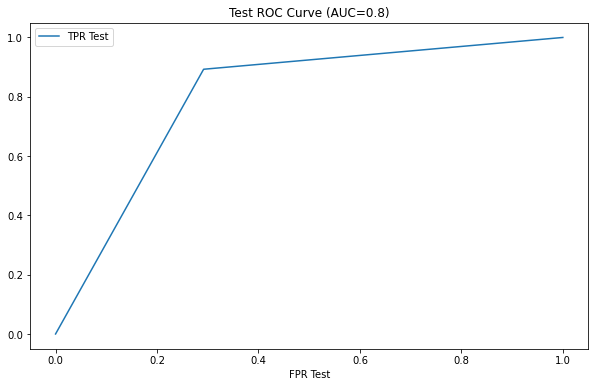

In [21]:
# Plot test set ROC curve
roc_df_test.plot(figsize = (10,6), x="FPR Test", y="TPR Test", title=f"Test ROC Curve (AUC={auc_test})")

---

# SVM Classifier

In [100]:
svm_classifier = SVC(kernel='linear', max_iter=500)
svm_classifier

SVC(kernel='linear', max_iter=500)

In [101]:
svm_classifier.fit(X_train_scaled, y_train)

/Users/stuartperry/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(kernel='linear', max_iter=500)

In [102]:
# Score the accuracy
svm_classifier.score(X_train_scaled, y_train)

0.6737973137973138

In [103]:
# Make predictions using the test data
svm_predictions = svm_classifier.predict(X_test_scaled)
svm_predictions_decoded = y_encoder.inverse_transform(svm_predictions)

In [104]:
# Display the confusion matrix
svm_cm = confusion_matrix(y_test_decoded, svm_predictions_decoded)
svm_cm = pd.DataFrame(confusion_matrix(y_test_decoded, svm_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
svm_cm

,Failed,Successful
Failed,12,2849
Successful,28,5886


In [105]:
# Calculate classification report
print(classification_report(y_test_decoded, svm_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.30      0.00      0.01      2861
  successful       0.67      1.00      0.80      5914

    accuracy                           0.67      8775
   macro avg       0.49      0.50      0.41      8775
weighted avg       0.55      0.67      0.54      8775



---
# SKLearn Neural Network Classifier

In [42]:
# init and fit Neural Networks classifier
nn_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 2), random_state=1)

In [43]:
# Fit the data
nn_classifier.fit(X_train_scaled, y_train)

/Users/stuartperry/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(4, 2), random_state=1,
              solver='lbfgs')

In [44]:
nn_classifier.score(X_test_scaled, y_test)

0.762962962962963

In [61]:
# Make predictions using the test data
nn_predictions = nn_classifier.predict(X_test_scaled)
nn_predictions_decoded = y_encoder.inverse_transform(nn_predictions)

dtype('int64')

In [46]:
# Display the confusion matrix
nn_cm = confusion_matrix(y_test_decoded, nn_predictions_decoded)
nn_cm = pd.DataFrame(confusion_matrix(y_test_decoded, nn_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
nn_cm

,Failed,Successful
Failed,1581,1280
Successful,800,5114


In [47]:
# Calculate classification report
print(classification_report(y_test_decoded, nn_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.66      0.55      0.60      2861
  successful       0.80      0.86      0.83      5914

    accuracy                           0.76      8775
   macro avg       0.73      0.71      0.72      8775
weighted avg       0.76      0.76      0.76      8775



---
 # XGBoost Classifier

In [48]:
# init datasets as XGB matrices
xgb_train = xgb.DMatrix(np.array(X_train_scaled), label=np.array(y_train))
xgb_test = xgb.DMatrix(np.array(X_test_scaled), label=np.array(y_test))

# specify parameters via map
param = {
    'max_depth':5, 
    'eta':1, 
    'num_class':2, 
    'gamma':0,
    'max_depth':6,
    'min_child_weight':10,
    'num_parallel_tree':1
    }
num_round = 5

# fit XGB classifier
xgb_classifier = xgb.train(param, xgb_train, num_round)

[17:30:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [63]:
# generate predictions
xgb_predictions = xgb_classifier.predict(xgb_test).astype(int)

dtype('int64')

In [64]:
xgb_predictions_decoded = y_encoder.inverse_transform(xgb_predictions)

In [65]:
# Display the confusion matrix
xgb_cm = confusion_matrix(y_test_decoded, xgb_predictions_decoded)
xgb_cm = pd.DataFrame(confusion_matrix(y_test_decoded, xgb_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
xgb_cm

,Failed,Successful
Failed,1918,943
Successful,701,5213


In [66]:
# Calculate classification report
print(classification_report(y_test_decoded, xgb_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.73      0.67      0.70      2861
  successful       0.85      0.88      0.86      5914

    accuracy                           0.81      8775
   macro avg       0.79      0.78      0.78      8775
weighted avg       0.81      0.81      0.81      8775

